# Creating a Diffusion Model to Generate Target Positions

We imagine that for any natural language instruction, there is a sort of *heatmap* over visual space that corresponds reasonable end-effector positions correlating to the task. And, additionally, we imagine that this heatmap would be sufficient to control a robot's behavior. However, prior approaches that use visual planning (e.g., RVT), fail to take advantage of large-scale, pretrained internet data. This is called an *energy-based* policy, and it implicitly determines how to act.

Cheng Chi and colleagues at Columbia realized that instead of using energy-based models, we can use score matching methods (a.k.a. diffusion). However, they did not condition it to use multiple views, nor did they train on a large dataset meant for natural language inference.

I hypothesize that this is because it is difficult to repurpose existing pretrained models in a ``multi-view" transformer. Instead, I stipulate that a *single model* acting from multiple viewpoints will suffice.


## Mathematics of Diffusion

Each view generates a component of the score function. An x-view predicts $\Delta_{y, z}$, a y-view predicts $\Delta_{x, z}$, and a z-view predicts $\Delta_{x, y}$. Combined, these allow us to infer how an end-effector position should evolve. The nice thing is to realize the symmetry here: The same model for the x- and y-views can be used to predict $\Delta_{y, z}$ and $\Delta_{x, z}$ in *image space* instead of world space.

We note additionally that in order for diffusion to work, the probability distribution we wish to model must not be too far away from an i.i.d. Gaussian distribution. Think about the stochastic differential equation that guides the reverse diffusion process. If our underlying distribution has variables in the range $[-10, 10]$, but we sample noise from $x \sim \mathcal{N}(0, I)$, then we will need to make samples that are $10$ S.D. away from the underlying noise. This means it's incredibly unlikely / not well-incentivized for any diffusion model to predict these samples.

So, we scale EEF positions to the cube $[-1, 1]^3$.

I will assume that the reader is familiar with DDPM, NCSM from Yang Song's blog, and solving differential equations with Euler's method, so I will not talk about the intuition, and just write about what I am using.

We apply a denoising process. Assume that we have a signal-to-noise ratio schedule denoted by $\overline{\alpha}$. We can then calculate $\beta$ values such that $\overline{\alpha}_i = \prod_{k = 1}^{i} \alpha_k$, where $\alpha_k = 1 - \beta_k$. We can interpret $\beta_k$ as the amount of noise added at step $k$ during the forward diffusion process. This generates a set of noised samples at different noise levels $\sigma_t = \alpha_t$.

Basically, $\tilde x_t \sim \mathcal{N}(\sqrt{1 - \overline{\alpha_t}} x, \sigma_t^2) = \sqrt{1 - \overline{\alpha_t}} x + \epsilon \sigma_t$, where $\epsilon \sim \mathcal{N}(0, I)$. The true noise added to $x$ is $\epsilon$, and this is what our model is trained to predict: $p(\epsilon; \tilde x_t, \overline{\alpha_t})$. From here, we can calculate $\tilde x_{t - 1}$, which is the slightly less noisy version of $\tilde x_t$. We progressively apply this until we reach $x_0$, which is the original sample.

Instead of calculating the loss at all timesteps $t$, we tend to do Monte Carlo sampling. That is, we sample a random noise level $\sigma_t$ according to some distribution (sometimes, $\log \sigma \sim \mathcal{N}(P_{mean}, P_{std}^2)$, which promotes better predictions specifically at noise level $P_{mean}$). We also rescale loss values by some coefficient $\lambda(\sigma)$, typically $\lambda(\sigma) = \sigma^{-2}$ which makes baseline loss equal to $1$ when using MSE (inversely with variance).



## Training with Diffusion

Enough talk, let's train!


### Loading demonstration data

We use the RLBench dataset for this.

In [1]:

import torch

from rlbench.action_modes.action_mode import MoveArmThenGripper
from rlbench.action_modes.arm_action_modes import JointVelocity
from rlbench.action_modes.gripper_action_modes import Discrete
from rlbench.environment import Environment
from rlbench.tasks import OpenDrawer
from rlbench.observation_config import ObservationConfig

import torch
import torch.utils.data

# from voxel_renderer import VoxelRenderer

# Get some observations
env = Environment(
    MoveArmThenGripper(arm_action_mode=JointVelocity(), gripper_action_mode=Discrete()),
    '/scratch/gsk6me/RLBench_Data/train',
    obs_config=ObservationConfig(),
    headless=True)
env.launch()

task = env.get_task(OpenDrawer)

print("Getting demos...")
demos = task.get_demos(8, live_demos=False)

env.shutdown()


Getting demos...


### Making training targets

We convert our demonstrations to $image \mapsto (x, y)$ pairs. We will also add language conditioning (eventually). To be honest, it would be cool to make an end-to-end language model trainer for this, for example by adding some kind of ``readout token". Maybe I can consider using LLaVA?

For example, we get a couple images of a scene, and then we reason about how to act. From there, we use LLaVA + a KV cache to diffuse the action from multiple views simultaneously.


In [17]:
from voxel_renderer_slow import VoxelRenderer
from demo_to_state_action_pairs import create_orthographic_labels

device = 'cuda'

SCENE_BOUNDS = [
    -0.3, -0.5,
    0.6, 0.7,
    0.5, 1.6,
]
VOXEL_IMAGE_SIZE = 224
BACKGROUND_COLOR = torch.tensor([0, 0, 0], device=device)
# Use this to generate the input images.
renderer = VoxelRenderer(SCENE_BOUNDS, VOXEL_IMAGE_SIZE, BACKGROUND_COLOR, device=device)

images = []
positions = []

for demo in demos:
    for (images_, positions_) in create_orthographic_labels(demo, renderer, device=device):
        # `images_` and `positions_` are sorted into images along x, y, and z axes, respectively.
        # Flip the y axis.
        images.extend([image.permute(2, 0, 1).flip(1) for image in images_])
        positions.extend([torch.tensor(pos, device=device) for pos in positions_])

images = torch.stack(images)
positions = torch.stack(positions)

# Create a dataset of images -> 2D positions.
dataset = torch.utils.data.TensorDataset(images, positions)


In [13]:
import os
os.environ['HUGGINGFACE_HUB_CACHE'] = '/scratch/' + os.environ['USER'] + '/huggingface_cache'

import transformers

# Load LLaVA model.
model: transformers.LlavaForConditionalGeneration = transformers.LlavaForConditionalGeneration.from_pretrained("llava-hf/llava-1.5-7b-hf") # type: ignore
model = model.to(device=device)
processor = transformers.AutoProcessor.from_pretrained("llava-hf/llava-1.5-7b-hf") # type: ignore


config.json:   0%|          | 0.00/950 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/70.1k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.18G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/141 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/557 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.33k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/41.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/438 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


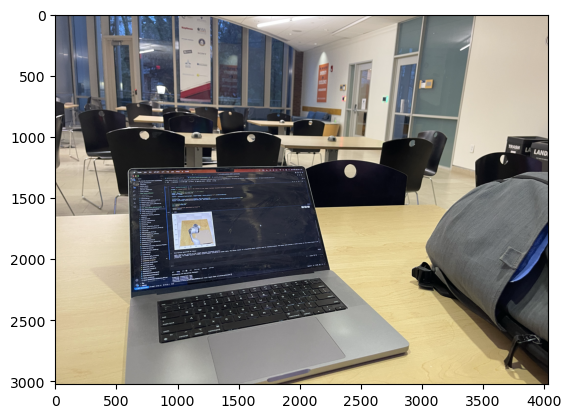

Description generated by Llava:

USER: What's the content of the image?
ASSISTANT: The image features a laptop computer sitting on a table in a room. The laptop is open and appears to be in use. The room also contains several chairs, some of which are placed around the table, and others are scattered throughout the space.


In [22]:
import matplotlib.pyplot as plt
import PIL.Image as Image
import numpy as np

prompt = "<image>\nUSER: What's the content of the image?\nASSISTANT:"

image = Image.open("IMG_8400.png")
image_np = np.array(image)

inputs = processor(text=prompt, images=image, return_tensors="pt").to(device=device)

# Generate
generate_ids = model.generate(**inputs, max_new_tokens=50)
result = processor.batch_decode(generate_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0]


# Visualize the image
plt.imshow(image_np)
plt.show()

print("Description generated by Llava:")
print(result)


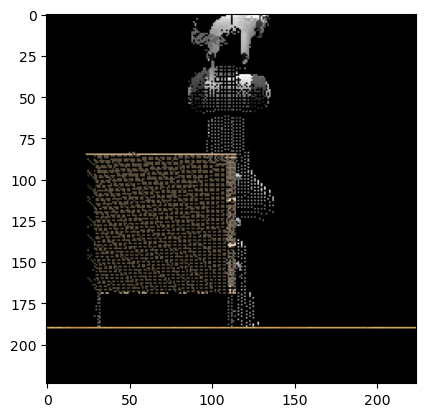

Description generated by Llava:

USER: What's the content of the image?
ASSISTANT: The image is a black and white photo of a dark room.


In [24]:
image = images[0]
image_np = image.cpu().permute(1, 2, 0).numpy()

inputs = processor(text=prompt, images=image, return_tensors="pt").to(device=device)

# Generate
generate_ids = model.generate(**inputs, max_new_tokens=50)
result = processor.batch_decode(generate_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0]


# Visualize the image
plt.imshow(image_np)
plt.show()

print("Description generated by Llava:")
print(result)

### Observations

Llava seems great for photorealistic scenarios, but not for RLBench-simulated data. Perhaps we can give Llava a description of the objects in the room to account for the photorealism gap. I wonder if Llava can locate objects that it is asked to find.


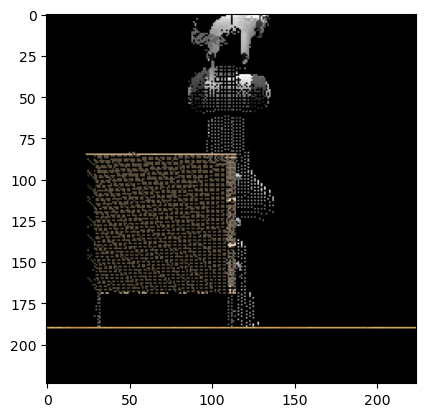

Description generated by Llava:

USER: There is a drawer here. What direction is it facing?
ASSISTANT: The drawer is facing upwards.


In [29]:
image = images[0]
image_np = image.cpu().permute(1, 2, 0).numpy()

inputs = processor(text="<image>\nUSER: There is a drawer here. What direction is it facing?\nASSISTANT:", images=image, return_tensors="pt").to(device=device)

# Generate
generate_ids = model.generate(**inputs, max_new_tokens=50)
result = processor.batch_decode(generate_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0]


# Visualize the image
plt.imshow(image_np)
plt.show()

print("Description generated by Llava:")
print(result)

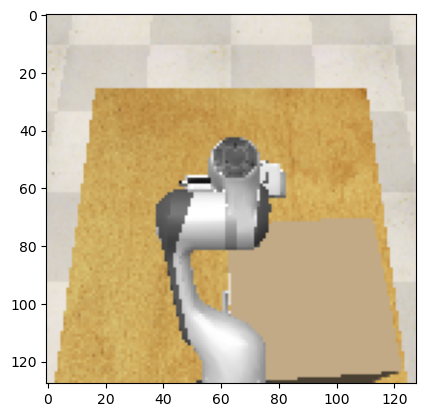

Description generated by Llava:

USER: There is a drawer here. What direction is it facing?
ASSISTANT: The drawer is facing upwards.


In [30]:
image = demos[0][0].overhead_rgb
image_np = image

inputs = processor(text="<image>\nUSER: There is a drawer here. What direction is it facing?\nASSISTANT:", images=image, return_tensors="pt").to(device=device)

# Generate
generate_ids = model.generate(**inputs, max_new_tokens=50)
result = processor.batch_decode(generate_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0]


# Visualize the image
plt.imshow(image_np)
plt.show()

print("Description generated by Llava:")
print(result)

### Observations

It seems that in any of these non-photorealistic scenes, Llava has a very hard time describing them. I fear that this will make it hard to train models in simulation. But anyway: I will see if I can use a transformer to denoise future keypoint locations effectively.


## Model Architecture

We're getting there!

In [156]:
from positional_encoding import PositionalEncoding

# Naïve approach that will surely be updated.
class VisualPlanDiffuser(torch.nn.Module):
    def __init__(self, clip: transformers.CLIPVisionModel):
        super().__init__()

        self.clip = clip
        d_model = clip.config.hidden_size
        self.readout = torch.nn.Linear(d_model, 2)
        self.positional_encoding = PositionalEncoding(n_position_dims=3, n_encoding_dims=d_model)
        self.mha = torch.nn.MultiheadAttention(d_model, num_heads=8, batch_first=True)

    def forward(self, pixel_values: torch.FloatTensor, plan_location: torch.Tensor) -> torch.Tensor:
        # Encode the image.
        image_features = self.clip.forward(pixel_values)
        image_cls_features = image_features.last_hidden_state[:, 0, :]
        image_spatial_features = image_features.last_hidden_state[:, 1:, :]

        # Use spatial features to denoise plan location.
        plan_token = self.positional_encoding(plan_location)

        plan_token, _ = self.mha.forward(query=plan_token.unsqueeze(0), key=image_spatial_features, value=image_spatial_features)
        predicted_noise = self.readout(plan_token)[:, 0, :]
        
        return predicted_noise


In [ ]:
# Load CLIP, our visual backbone. May also consider adding Segment Anything as a visual backbone, if it is fast enough.
clip = transformers.CLIPVisionModel.from_pretrained("openai/clip-vit-base-patch16")
clip = clip.to(device=device)
clip_processor = transformers.CLIPProcessor.from_pretrained("openai/clip-vit-base-patch16") # type: ignore

In [158]:
import tqdm


diffuser = VisualPlanDiffuser(clip).to(device=device)
diffuser.clip.requires_grad_(False)
optim = torch.optim.Adam([p for p in diffuser.parameters() if p.requires_grad], lr=1e-3)

betas = torch.linspace(0.002, 0.5, 10, device=device)
alphas = 1 - betas
alphas_cumprod = torch.cumprod(alphas, dim=0)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1 - alphas_cumprod)

# Train the diffuser.
for epoch in range(10):
    for i, (image, position) in (pbar := tqdm.tqdm(enumerate(dataset), desc='Epoch ' + str(epoch + 1))):
        pixel_values = clip_processor(images=image, return_tensors="pt").to(device=device).pixel_values

        # Normalize position
        position_normalized = (position - 112.0) / 224.0

        timestep = torch.randint(0, 10, ()).item()
        noise = torch.randn(position.shape, device=device)
        noisy_position = sqrt_alphas_cumprod[timestep] * position_normalized + alphas_cumprod[timestep] * noise

        # Need to condition on timestep
        prediction = diffuser.forward(pixel_values, torch.cat([noisy_position, torch.tensor([timestep], device=device)]).unsqueeze(0))

        optim.zero_grad()
        # yes this is supposed to be the score function not the actual position
        loss = torch.nn.functional.mse_loss(prediction, noise.unsqueeze(0))
        loss.backward()
        optim.step()

        pbar.set_postfix(loss=loss.item())



Epoch 1: 0it [00:00, ?it/s]

Epoch 1: 72it [00:01, 45.72it/s, loss=1.07]   
Epoch 2: 72it [00:01, 41.25it/s, loss=0.232]  
Epoch 3: 72it [00:01, 43.16it/s, loss=0.138]  
Epoch 4: 72it [00:01, 41.40it/s, loss=0.198] 
Epoch 5: 72it [00:01, 44.23it/s, loss=0.77]  
Epoch 6: 72it [00:01, 44.08it/s, loss=0.194] 
Epoch 7: 72it [00:01, 44.35it/s, loss=3.84]  
Epoch 8: 72it [00:01, 44.28it/s, loss=0.0838]  
Epoch 9: 72it [00:01, 39.83it/s, loss=1.06]   
Epoch 10: 72it [00:01, 44.34it/s, loss=1.04]  


In [35]:
from transformers.models.clip.modeling_clip import CLIPVisionTransformer, BaseModelOutputWithPooling
from typing import Optional, Union, Tuple

# Modify the CLIP forward pass to accept our special "plan location" token as an input.
def custom_clip_vision_transformer_forward(
    self: CLIPVisionTransformer,
    pixel_values: Optional[torch.FloatTensor] = None,
    output_attentions: Optional[bool] = None,
    output_hidden_states: Optional[bool] = None,
    return_dict: Optional[bool] = None,
    plan_location: Optional[torch.FloatTensor] = None,
) -> Union[Tuple, BaseModelOutputWithPooling]:
    output_attentions = output_attentions if output_attentions is not None else self.config.output_attentions
    output_hidden_states = (
        output_hidden_states if output_hidden_states is not None else self.config.output_hidden_states
    )
    return_dict = return_dict if return_dict is not None else self.config.use_return_dict

    if pixel_values is None:
        raise ValueError("You have to specify pixel_values")

    hidden_states = self.embeddings(pixel_values)
    hidden_states = self.pre_layrnorm(hidden_states)

    encoder_outputs = self.encoder(
        inputs_embeds=hidden_states,
        output_attentions=output_attentions,
        output_hidden_states=output_hidden_states,
        return_dict=return_dict,
    )

    last_hidden_state = encoder_outputs[0]
    pooled_output = last_hidden_state[:, 0, :]
    pooled_output = self.post_layernorm(pooled_output)

    if not return_dict:
        return (last_hidden_state, pooled_output) + encoder_outputs[1:]

    return BaseModelOutputWithPooling(
        last_hidden_state=last_hidden_state,
        pooler_output=pooled_output,
        hidden_states=encoder_outputs.hidden_states,
        attentions=encoder_outputs.attentions,
    )


CLIPVisionConfig {
  "_name_or_path": "openai/clip-vit-base-patch16",
  "attention_dropout": 0.0,
  "dropout": 0.0,
  "hidden_act": "quick_gelu",
  "hidden_size": 768,
  "image_size": 224,
  "initializer_factor": 1.0,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "model_type": "clip_vision_model",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "projection_dim": 512,
  "transformers_version": "4.38.2"
}



tensor(0.9990, device='cuda:0') tensor(0.0447, device='cuda:0') tensor([ 1.0948, -2.1063], device='cuda:0') tensor([-0.1281, -0.8364], device='cuda:0')


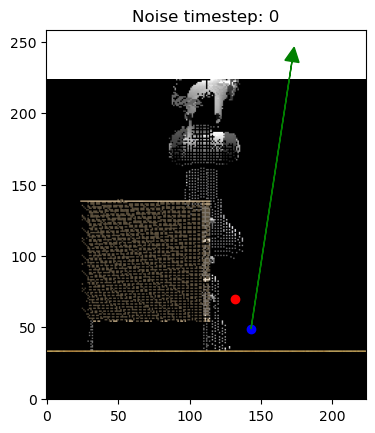

In [183]:
# Let's plot the predictions.

with torch.no_grad():
    image = dataset[0][0]
    position = dataset[0][1]
    
    # Normalize position
    position_normalized = (position - 112.0) / 224.0


    timestep = 0 # torch.randint(0, 10, ()).item()
    noise = torch.randn(position.shape, device=device)
    noisy_position = sqrt_alphas_cumprod[timestep] * position_normalized + sqrt_one_minus_alphas_cumprod[timestep] * noise

    pixel_values = clip_processor(images=image, return_tensors="pt").to(device=device).pixel_values
    prediction = diffuser.forward(pixel_values, torch.cat([noisy_position, torch.tensor([timestep], device=device)]).unsqueeze(0))[0]
    
    print(sqrt_alphas_cumprod[timestep], sqrt_one_minus_alphas_cumprod[timestep], noise, prediction)

noisy_position_denormalized = noisy_position * 224 + 112

# Visualize
plt.title("Noise timestep: " + str(timestep))
plt.imshow(image.cpu().permute(1, 2, 0).flip(0), origin='lower')
plt.scatter(position[0].item(), position[1].item(), c='r')

noisy_x = noisy_position_denormalized[0].item()
noisy_y = noisy_position_denormalized[1].item()

plt.scatter(noisy_x, noisy_y, c='b')
# draw arrow in opposite direction of noise_pred, from noisy_position
plt.arrow(noisy_x, noisy_y, -prediction[0].item() * 224, -prediction[1].item() * 224, head_width=10, head_length=10, fc='g', ec='g')
plt.show()
